In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd
import pdfplumber
import numpy as np
import joblib

In [2]:
data = pd.read_csv('dataset.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
data.head(n=5)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_299,width,height,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,label
0,-0.355680,-0.248500,0.32543,-0.038704,0.62980,0.398140,0.23029,0.007171,-0.11763,-0.90891,...,-0.042316,130.392400,45.025,54.050,102.16705,184.442400,57.14205,1,45.025,1
1,1.120200,0.193420,-0.16196,-1.178900,0.44859,0.257830,0.16437,0.263490,-0.60810,2.72750,...,0.386610,154.931025,45.025,199.400,102.16705,354.331025,57.14205,1,45.025,1
2,-0.534460,0.405230,-0.64334,-0.005094,0.49263,-0.360030,0.15781,-0.843470,0.36604,3.82510,...,-0.139580,96.636100,16.225,54.050,120.50725,150.686100,104.28225,2,16.225,0
3,0.079878,0.184400,-0.75717,0.462540,0.64727,-0.142300,0.10444,-0.608470,-0.21654,2.25200,...,0.617300,83.034600,13.800,64.875,181.37700,147.909600,167.57700,3,13.800,1
4,0.049935,-0.096466,-0.27315,-0.243580,0.13666,-0.044576,-0.38256,0.138110,0.66757,-1.22940,...,0.010549,21.858600,10.200,64.875,202.09200,86.733600,191.89200,2,10.200,0


In [4]:
import spacy
nlp = spacy.load("en_core_web_lg")

C:\Users\yanni\New folder\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\yanni\New folder\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [5]:
resume_dir = 'Donna_Robbins.pdf'

def word_to_vector(word):
    token = nlp(word)
    if token.has_vector:
        return token.vector
    else:
        # fallback for unknown words
        return np.zeros(300)
        
def extract_resume():
    resume_data = []
    with pdfplumber.open(f'{resume_dir}') as pdf:
        for page in pdf.pages:
            words = page.extract_words(extra_attrs=["fontname", "size"])
            for w in words:
                resume_data.append({"word": w["text"],
                            "width": w["width"],
                            "height": w["height"],
                            "left_distance": w["x0"], 
                            "bottom_distance": w["bottom"], 
                            "right_distance": w["x1"], 
                            "top_distance": w["top"],
                            "fontname": w["fontname"],
                            "fontsize": w["size"]})
        im = pdf.pages[0].to_image(resolution=100)

    resume_data = pd.DataFrame(resume_data)
    resume_data['original_word'] = resume_data['word']
    resume_data['word'] = resume_data['word'].apply(lambda x: word_to_vector(x))
    embedding_matrix = np.vstack(resume_data['word'].values)
    embedding_df = pd.DataFrame(embedding_matrix, index=resume_data.index)
    embedding_df.columns = [f"emb_{i}" for i in range(embedding_df.shape[1])]
    meta_df = resume_data.drop(columns=['word'])
    resume_data_emb = pd.concat([embedding_df, meta_df], axis=1)

    encoder = joblib.load('ordinal_encoder.pkl')
    resume_data_emb['fontname'] = encoder.transform(resume_data_emb['fontname'])
    return resume_data_emb, im

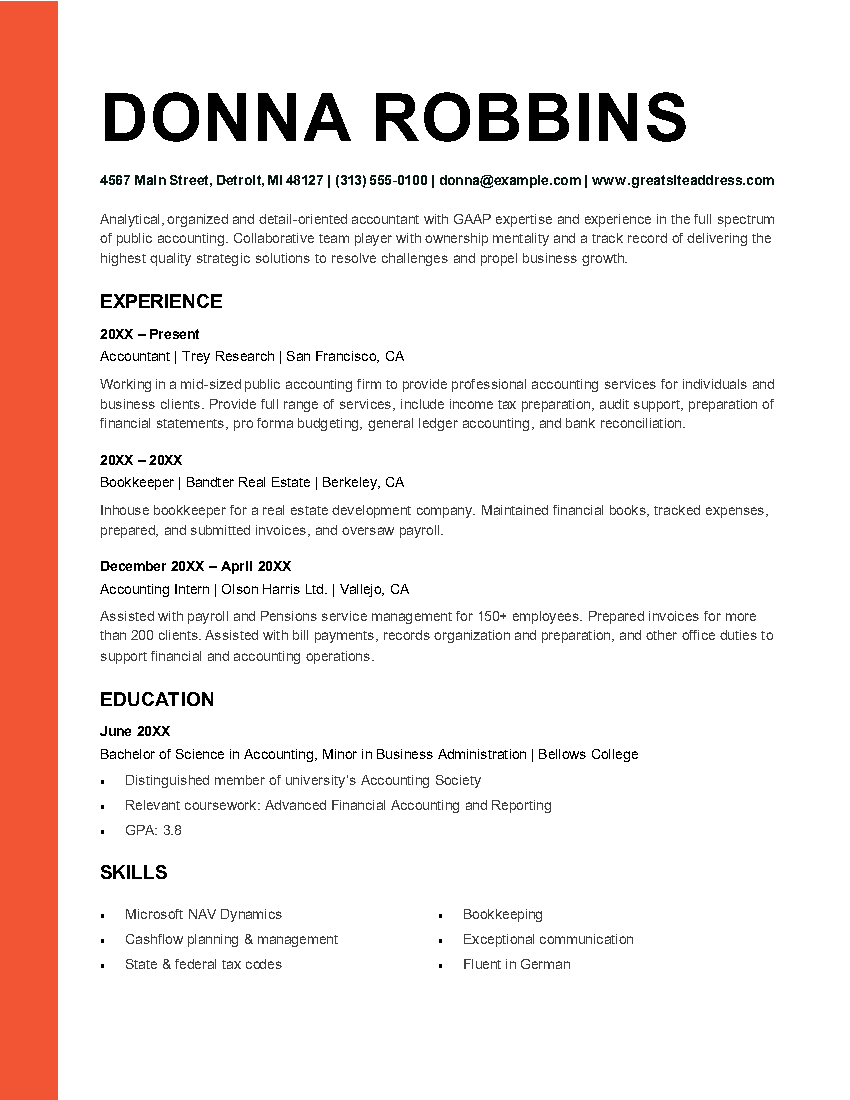

In [6]:
resume_data_emb, im = extract_resume()
im

In [7]:
resume_data_emb.head(n=5)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_299,width,height,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,original_word
0,-0.487900,0.069221,0.221830,0.266330,0.114560,0.377930,0.997770,-0.098329,-0.065525,0.019175,...,-0.411690,181.006225,48.025,72.0750,111.55525,253.081225,63.53025,16.0,48.025,DONNA
1,-0.331480,0.660450,0.398440,0.307320,0.032149,0.345830,0.142790,-0.348760,0.766100,-0.168600,...,-0.277320,228.695050,48.025,267.2700,111.55525,495.965050,63.53025,16.0,48.025,ROBBINS
2,0.049935,-0.096466,-0.273150,-0.243580,0.136660,-0.044576,-0.382560,0.138110,0.667570,-1.229400,...,0.010549,21.858600,10.200,72.0750,135.44200,93.933600,125.24200,17.0,10.200,4567
3,0.237490,0.133610,-0.093727,0.440170,0.052720,0.099604,-0.228480,-0.142400,0.044628,1.931000,...,0.074287,23.021400,10.200,96.6468,135.44200,119.668200,125.24200,17.0,10.200,Main
4,0.309249,0.354291,-0.133475,-0.179407,0.272835,0.293270,-0.096508,-0.148559,-0.464475,2.270300,...,0.330060,31.599600,10.200,121.8306,135.44200,153.430200,125.24200,17.0,10.200,"Street,"


In [8]:
X_train = data.iloc[:, :-1]
y_train = data.iloc[:, -1]

In [9]:
rf = RandomForestClassifier()

In [10]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
original_words = resume_data_emb.iloc[:, -1]
resume_data_emb = resume_data_emb.iloc[:, :-1 ]
y_pred = rf.predict(resume_data_emb)

In [12]:
y_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int64)

In [13]:
def words_identified_as_titles(y_pred: int, original_words: object) -> None:
    print('--Words Identified As Title--')
    i = 0
    for pred in y_pred:
        if pred == 1:
            print(f'{original_words[i]}')
        i += 1

In [14]:
words_identified_as_titles(y_pred, original_words)

--Words Identified As Title--
DONNA
ROBBINS
EXPERIENCE
EDUCATION
SKILLS
